# Importo y defino todo 

In [18]:
!pip install fermat

In [19]:
import fermat as F
import numpy as np
import scipy.sparse as sp
import time
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist,cdist, squareform
import scipy
import warnings
warnings.filterwarnings('ignore')


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def cero(a,b):
  return 0, np.zeros(a.shape)

importe lo necesario y armo las funciones que me dicen el costo de transportar una serie de puntos con fermat dada la matriz de distancias de fermat (lo que usaba en transporte optimo antes), tambien hago su gradiente y pruebo

In [20]:
#Builds fermat graph given data, alpha, method (and if 'D' is chosen with k_fermat neighbours)
#RETURNS: fermat distance matrix between points of data and a KD-Tree 


def fermat_graph(data,alpha,method='FW',k_fermat=30):
    model=F.Fermat(alpha, path_method=method,k=k_fermat)
    model.fit(np.matrix(distance_matrix(data,data)))
    fermat_distances = model.get_distances()
    tree = KDTree(data)
    return fermat_distances,tree
              

#Computes fermat_cost of transporting initialData to x with the given fermat_distances
#initial data will be points

#It uses the KD-Tree built with fermat_graph() as well as a parameter 'k' which is 
#the amount of neighbours to look at when getting the fermat distance for a point that
#is not in the graph (including it may be computationally expensive)
#It also recieves the original data and the alpha used to build fermat_distances
              
#RETURNS: fermat cost and gradient of that cost
def fermat_cost_cuad(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)*2*dist
        res+=dist**2              
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient
#ojoo cambie para la DISTANCIA AL CUADRADO!! 



#RETURNS: fermat cost and gradient of that cost
def fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)
        res+=dist              
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient



#Computes fermat distance between start  and end using fermat_distances
              
#it also recieves the KD-tree, numbre of neighbours to look at, and alpha used in fermat
              
#RETURNS: fermat distance between start and end, as well as the index of the k-nearest neighbour
#of end with smallest fermat distance to start
def fermat_dist(start,end,fermat_distances,tree,k,alpha):
    
    start_euclid_dist,start_ind=tree.query([start],k=1)
    idx=start_ind[0,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query([end],k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
        
    dist=min([ fermat_distances[idx,end_ind[0,i]]+end_euclid_dist[0,i] for i in range(end_euclid_dist.shape[1])])
    
    minim=np.argmin([ fermat_distances[idx,end_ind[0,i]] for i in range(end_ind.shape[1])]) 
    grad_idx=end_ind[0,minim] #index of k-nearest neighbour with smallest fermat_distance to idx.
    
    return dist+start_euclid_dist[0,0],grad_idx
              

#Here initialData are the points, and x the trasnportation of those
##UNUSED
def euclidean_cost(x,initialData):
    dim=initialData.shape[1]
    assert(initialData.shape[0]*dim==len(x))
    real_x=x.reshape(-1,dim)
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        res+=np.linalg.norm(initialData[i,:]-real_x[i,:])**2
        local_gradient=2*(real_x[i,:]-initialData[i,:])
        gradient[dim*i:(i+1)*dim]=local_gradient
    return res,gradient




Un fermat que paralieliza, sino es una tortuga. Idem euclidea

In [21]:
           
#RETURNS: fermat cost and gradient of that cost
def fermat_cost_cuad_fast(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    
    start_euclid_dist,start_ind=tree.query(initialData,k=1)
    idx=start_ind[:,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query(real_x,k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
    
    dist=([ [fermat_distances[idx[j],end_ind[j,i]]+end_euclid_dist[j,i] for i in range(end_euclid_dist.shape[1])] for j in range(end_euclid_dist.shape[0])])
    dist=np.array(dist)
    dist=np.min(dist,axis=1)
    
    minim=[[ fermat_distances[idx[j],end_ind[j,i]] for i in range(end_ind.shape[1])] for j in range(end_ind.shape[0])]  
    minim=np.argmin(minim,axis=1)
    
    grad_idx=[end_ind[j,minim[j]] for j in range(end_ind.shape[0])]
        
    distances=dist+start_euclid_dist[:,0]
    distances=distances.reshape(-1,1)
    
              
    q=data[grad_idx,:] 
    aux=alpha*(np.linalg.norm(q-real_x,axis=1)**(alpha-2)).reshape(-1,1)
    local_grad=aux*(real_x-q)*2*distances
    gradient=local_grad.flatten()
    res=np.linalg.norm(distances)**2   
    return res,gradient

def euclidean_cost_fast(x,initialData):
    assert(initialData.shape[0]*initialData.shape[1]==len(x))
    real_x=x.reshape(-1,initialData.shape[1])
    res=np.linalg.norm(np.linalg.norm(initialData-real_x,axis=1))**2
    gradient=2*(real_x-initialData).flatten()
    return res,gradient

Creo funciones del algoritmo propuesto por Tabak, Zhao, Triglia

In [22]:
def kernel(x,centro,b,dim):
  return np.exp(-(np.linalg.norm(x-centro)**2)/(2*b*b))/( (np.sqrt(2*np.pi)*b)*dim)

#ARMO LA MATRIZ C    

#vector con los valores z que hay, una matriz por filas paso
#viene en el mismo orden que los y
def armar_C(z,b=1):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    dim=z.shape[1]
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=kernel(z[j],z[i],b,dim)
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=1).reshape(-1,1) #CHECK, cambio axis 0 por 1
    return C


#VERSION DONDE Z ES CATEGORICO, SON ETIQUETAS, z es vector columna
def armar_C_categorico(z):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=0
            if(z[i]==z[j]):
                aux=1
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=1).reshape(-1,1) #CHECK, cambio axias 0 por 1
    return C

In [23]:
#matriz que tieneen el lugar ij al kernel(y_i,y_j) 
def kernel_matrix_y(y,h):
    pairwise_dists = squareform(pdist(y, 'euclidean'))
    return np.exp( -pairwise_dists**2/(2*(h**2))) #/ (np.sqrt( (2*np.pi)**dimension) )
    
    
#idem pero en el lugar ij esta el gradiente    
def grad_matrix_y(y,h):
    pairwise_dists=squareform(pdist(y,'euclidean'))
    #armo la matriz que tiene el escalar por el que multiplico a la direccion
    aux=np.exp( -pairwise_dists**2/(2*(h**2)))# / (np.sqrt( (2*np.pi)**dimension))
    aux=aux*(-1/(h**2))
    
    #simplemente hago en cada coordenada (De las d dimensiones) la resta de los y correspondeintes
    #en el lugar ij tendre y_i-y_j y eso luego lo multiplico por aux.
    unos=np.ones((y.shape[0],1))
    res=np.zeros((y.shape[0],y.shape[0],dimension))
    for d in range(dimension):
        res[:,:,d]=(y[:,d].reshape(-1,1)) @unos.T -  unos @ (y[:,d].reshape(-1,1)).T  
        res[:,:,d]=res[:,:,d]*aux
    return res


def kernel_matrix_y_centros(y,centros,h):
    pairwise_dists = cdist(y,centros, 'euclidean')
    return np.exp( -pairwise_dists**2/(2*(h**2)))# / (np.sqrt( (2*np.pi)**dimension) )

In [24]:
#AHORA DEFINO LAGRANGIANO Y SU GRADIENTE                
def lagrangiano(landa,kernel_matrix,f_matrix,C,cost,alpha): 
    return  cost+ landa * ( np.sum(    f_matrix.shape[1]*np.diag(kernel_matrix @ C)/ (np.sum(f_matrix,axis=1)**((alpha-1)/alpha) )  ) )
    
#el gradiente de la parte de la F del lagrangiano
def fgrad(y,grad_matrix,C): 
    dimension=y.shape[1]
    aux=np.zeros(y.shape).flatten()
    for i in range (y.shape[0]):
        local_grad=C[i,:]@grad_matrix[i,:,:]
        aux[i*dimension:(i+1)*dimension]= local_grad
    return aux

def fgrad_fast(y,grad_matrix,kernel_matrix,fgrad_matrix,f_matrix,C,alpha): 
    dimension=y.shape[1]
    #local_grad=np.zeros((y.shape[0],dimension))
    #for d in range (dimension):
    #   local_grad[:,d]=np.sum(C[:,:]*grad_matrix[:,:,d].T,axis=0) 
    #NO ES UN AXIS1 ACA????? deberia sumar sobre las filas sin el transpuesto TODO lo arreglo en la version mas rapida
    #CHECK, TODO!!

    arriba_deriv=np.sum((grad_matrix[:,:,:].T*C.T).T,axis=1)
    abajo_sin_deriv=np.sum(f_matrix,axis=1)**((alpha-1)/alpha)

    arriba_sin_deriv=np.diag(kernel_matrix@C)
    auxi=((alpha-1)/alpha) * (np.sum(f_matrix,axis=1)**(-1/alpha))
    abajo_deriv= ( np.sum(fgrad_matrix,axis=1).T*auxi.T  ).T
    local_grad=(    ( (arriba_deriv.T*abajo_sin_deriv.T).T - (abajo_deriv.T * arriba_sin_deriv.T).T ).T  /  (abajo_sin_deriv**2).T ).T
    #print(np.sum(f_matrix,axis=1))
    return (f_matrix.shape[1])*local_grad.flatten()

def fgrad_fast2(y,grad_matrix,C): 
    dimension=y.shape[1]
    #local_grad=np.zeros((y.shape[0],dimension))
    #for d in range (dimension):
    #   local_grad[:,d]=np.sum(C[:,:]*grad_matrix[:,:,d].T,axis=0) 
    #NO ES UN AXIS1 ACA????? deberia sumar sobre las filas sin el transpuesto TODO lo arreglo en la version mas rapida
    #CHECK, TODO!!
    local_grad=np.sum((grad_matrix.T*C.T).T,axis=1)
    return local_grad.flatten()


# derivo en y_i
def lagrangiano_grad(landa,cost_grad,f_grad):
    return cost_grad+landa*f_grad

In [25]:
#La cuenta de como actualizar el landamin,hace la cuenta de que desciendo en direccion de L_F (que aca llamo f_grad)
def landamin_actualizacion(cost_grad,f_grad):
    num=cost_grad@f_grad
    denom=f_grad@f_grad
    return num/denom

Hago ahora una función que corra el algoritmo!

In [26]:
def barycenter(yinitial,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function,landa_monotono=True,factor=1,categorical=True,b=1,callback=True):
    h_adapt=False
    if h==-1:
        h_adapt=True
    
    y=yinitial
    if categorical: 
        C=armar_C_categorico(z)
    else: 
        armar_C(z,b)
    landa=landa0
    learningrate=learningrate0
    n=0

    while (n<n_iter):
        if h_adapt:
            h=np.std(y)*1.06*(y.shape[0]**(-1/5))*factor
            
        learningrate=min(learningrate*2.01,learningrate0)

        cost,cost_grad=cost_function(y.flatten(),samples)
        grad_matrix=grad_matrix_y(y,h)
        f_grad=fgrad_fast2(y,grad_matrix,C)
        
        
        beta=landa*beta_adapt
        
        if landa_monotono:
            landamin=beta-landamin_actualizacion(cost_grad,f_grad)
            if(landamin>landa and landamin<landamax): 
                landa=landamin
            elif(landamin>landamax): 
                landa=landamax
        else:
            landa=beta-landamin_actualizacion(cost_grad,f_grad)

        gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
        yviejo=y
        costviejo=cost


        while(True):
            y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
            
            kernel_matrix_nuevo=kernel_matrix_y(y,h) 
            cost,cost_grad=cost_function(y.flatten(),samples)
            kernel_matrix_viejo=kernel_matrix_y_centros(y,yviejo,h)
            
            lag_nuevo=lagrangiano(landa,kernel_matrix_nuevo,C,cost)
            lag_viejo=lagrangiano(landa,kernel_matrix_viejo,C,costviejo)
            
            if(lag_nuevo<=lag_viejo): 
                break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)
            learningrate=learningrate/2             
        
        paso=learningrate*np.linalg.norm(gradienteLagrangiano)
        if callback: print("it: "+str(n)+", paso: "+str(paso)+", landa: "+str(landa)+", h:"+str(h))
        if paso<1e-7: landa=landa*1.1 
        n=n+1
    return y

-El h adaptativo achica mucho mas rapido la varianza!! Pero favorece tener outliers, si se me juntan varios puntos y unos quedan muy lejos, el h será muy chicos y estos puntos alejados no van a tener en cuenta a los otros.

-Los puntos se empiezana expandir para mejorar al principio, como despues pasa que los que se alejan hacia afuera se vienen al baricentro? Por qué pasaria? Ahi juega muy fuertemente la eleccion del h

-Cuan adaptativo elijo el beta (alpha del paper)? Cuan dependiente del caso e esto? hacer un adaptativo on 0.01 o 0.05 parece andar bien. Todo indicaria que cuanto mas leve el aumento de landa mejor.

-landa max??

-landa0, es muy relevante? Arranca igual si tomo uno muy chico.


### A implementar

Ir con un bandwith muy grande e ir achicandolo. NO pasarse de la rule of thumb, no pasarse de la del principio o ir actualizando!!No tenes que irse con el bandwidth muy chico, sensible a outliers. Recocido simulado de agrandar el h de la nada por si se te escapo algo?

Actualizacion del lambda? Tiene que ir creciendo necesariamente?

Dejar kernels gaussianos pero evaluarlos en la distancia de fermat! EL gradietne hay que actualizarlo tambien con el gradiente de fermat. ESo haria que los puntos se muevan siguiendo la geodesica (pesada por la densidad)

Rellenar el espacio con poca densidad de fermat y que gradualmente vaya aumentando hacia la misma sueprficie

Ver el tema del h

Ejemplo no singular de densidad

enchufar fermat en donde estan los kernels.

Ejemplos distintos: una curva menos pronunciada, otro ejemplo tipo el circulo? Una curva mas separada para afuera

# Defino Fermat Kernels y la funcion de baricentro con ellos

In [27]:
           
#RETURNS: fermat cost and gradient of that cost
def pairwise_fermat_dist(real_x,initialData,fermat_distances,tree,data,k,alpha,C):
    iguales=False if real_x.shape!=initialData.shape  else np.alltrue(np.abs(real_x-initialData)<1e-10)
    dimension=real_x.shape[1]
    originalshape0=real_x.shape[0]
    originalshape1=initialData.shape[0]
    
    res=0   
    
    start_euclid_dist,start_ind=tree.query(initialData,k=1)
    start_euclid_dist=np.power(start_euclid_dist,alpha)

    start_euclid_dist=np.tile(start_euclid_dist,(originalshape0,1))
    start_ind=np.tile(start_ind,(originalshape0,1))
    idx=start_ind[:,0]
    
    end_euclid_dist,end_ind=tree.query(real_x,k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
    end_euclid_dist=np.repeat(end_euclid_dist,originalshape1,axis=0)
    end_ind=np.repeat(end_ind,originalshape1,axis=0)
    
    real_x=np.repeat(real_x,originalshape1,axis=0) #me queda el punto 1 n veces, el 2 otras n veces y asi
    initialData=np.tile(initialData,(originalshape0,1)) #
    
    '''
    dist=([ [fermat_distances[idx[j],end_ind[j,i]]+end_euclid_dist[j,i] for i in range(end_euclid_dist.shape[1])] for j in range(end_euclid_dist.shape[0])])
    dist=np.array(dist)
    dist=np.min(dist,axis=1)
    
    minim=[[ fermat_distances[idx[j],end_ind[j,i]] for i in range(end_ind.shape[1])] for j in range(end_ind.shape[0])]  
    minim=np.argmin(minim,axis=1)
    '''
    
    
    dist=np.array([ fermat_distances[idx[:],end_ind[:,i]] for i in range(end_euclid_dist.shape[1])]).T
    dist=dist+end_euclid_dist
    dist=np.array(dist)
    dist=np.min(dist,axis=1)
    
    minim2=np.array([ fermat_distances[idx[:],end_ind[:,i]] for i in range(end_ind.shape[1])]).T 
    minim=np.argmin(minim2,axis=1)
    #maxim=np.argmax(minim2,axis=1)

    grad_idx=[end_ind[j,minim[j]] for j in range(end_ind.shape[0])]
    #grad_idx2=[end_ind[j,maxim[j]] for j in range(end_ind.shape[0])]
        
    distances=dist+start_euclid_dist[:,0]
    distances=distances.reshape(originalshape1,originalshape0).T #traspongo porque calcule al reves

    if iguales:
      np.fill_diagonal(distances,0)#cada uno con sigo mismo esta a distancia 0
      #FUNDAMENTAL ESTO PORQUE SINO BUSCO ALEJARME MUCHO DE TODO Y EL COSTO VA A DAR 0
              
    q=data[grad_idx,:] 
    #q2=data[grad_idx2,:]
    
    aux=alpha*(np.linalg.norm(q-real_x,axis=1)**(alpha-2)).reshape(-1,1)
    #aux2=alpha*(np.linalg.norm(q2-real_x,axis=1)**(alpha-2)).reshape(-1,1)
    local_grad=aux*(real_x-q) #apunto en la direccion opuesta al q
    #local_grad2=-aux2*(real_x-q2) #apunto en la direccion del q2
    grad=local_grad.reshape(originalshape0,originalshape1,dimension)
    if iguales:
      np.einsum('iij->ij',grad)[...] = 0   #ME REEMPLAZA EL FOR!

    #grad2=local_grad2.reshape(originalshape0,originalshape1,dimension)
    #np.einsum('iij->ij',grad2)[...]
    #grad=np.zeros((originalshape0,originalshape0,dimension))
    #for d in range(dimension):
    #    grad[:,:,d]=local_grad[:,d].reshape(originalshape0,originalshape0)
    #    np.fill_diagonal(grad[:,:,d],0)
    #print(np.alltrue(np.abs(grad2-grad)<1e-12))
    #gradposta=np.where(C<0,grad,grad2)
    
    return distances,grad #PARA INCLUIR GRADIENTE PONER ACA GRADPOSTA

In [28]:
#matriz que tieneen el lugar ij al kernel(y_i,y_j) 
def kernel_matrix_y_centros_fermat(y,centros,h,fermat_distances,tree,data,k,alpha):
    dimension=2
    assert(y.shape==centros.shape)
    Cfalsa=np.zeros((y.shape[0],y.shape[0],y.shape[1])) #basicamente no importa el gradiente aca. 
    pairwise_dists,trash = pairwise_fermat_dist(y,centros,fermat_distances,tree,data,k,alpha,Cfalsa)
    return np.exp( -pairwise_dists**2/(2*(h**2)))# / ((np.sqrt( 2*np.pi)*h)**dimension)


def kernel_matrix_y_fermat(y,h,fermat_distances,tree,data,k,alpha,PD):
    dimension=2
    return np.exp( -PD**2/(2*(h**2)))# / ((np.sqrt( 2*np.pi)*h)**dimension)
    
    
#idem pero en el lugar ij esta el gradiente    
def grad_matrix_y_fermat(y,h,fermat_distances,tree,data,k,alpha,PD,G_PD):
    dimension=2
    pairwise_dists=PD
    grad = G_PD
    aux=np.exp( -pairwise_dists**2/(2*(h**2)))# / ((np.sqrt( 2*np.pi)*h)**dimension)
    aux=aux*(-pairwise_dists/(h**2))
    
    #simplemente hago en cada coordenada (De las d dimensiones) multiplicar por lo que seria el gradiente
    #de pairwise_dists que es lo que falta para completar regla de la cadena.

    #res=np.zeros(grad.shape)
    res2=(grad.T*aux.T).T    #ESTO ME SACA EL FOR!
    #for d in range(dimension):
    #    res[:,:,d]=grad[:,:,d]*aux
    #print(np.alltrue(np.abs(res2-res)<1e-12))
    return res2


In [29]:
def barycenter_fermat(yinitial,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function,f_dist,tree,data,k,alpha,quant=0.95,quant2=0,tasaenfrio=0.8,factor=1,categorical=True,b=1,callback=True,landa_monotono=True):
    
    
    if categorical: 
        C=armar_C_categorico(z)
    else: 
        C=armar_C(z,b)
    y=yinitial
    h_adapt=False

    Crep=np.repeat(C[:, :, np.newaxis], yinitial.shape[1], axis=2)

    PD,G_PD=pairwise_fermat_dist(y,y,f_dist,tree,data,k,alpha,Crep)


    if h==-1:
        h_adapt=True
        h=np.quantile(PD.flatten(),quant)*factor
    control=np.quantile(PD.flatten(),quant2)    
    
    kernel_matrix_nuevo=kernel_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,PD)

    fPD,fG_PD=pairwise_fermat_dist(y,data,f_dist,tree,data,k,alpha,Crep)
    f_matrix_nuevo=kernel_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,fPD)


    landa=landa0
    learningrate=learningrate0
    n=0

    while (n<n_iter):
            
        learningrate=min(learningrate*2.01,learningrate0)

        cost,cost_grad=cost_function(y.flatten(),samples)
                

        fgrad_matrix=grad_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,fPD,fG_PD)
        grad_matrix=grad_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,PD,G_PD) 
        f_grad=fgrad_fast(y,grad_matrix,kernel_matrix_nuevo,fgrad_matrix,f_matrix_nuevo,C,alpha)  #ACA HAY QUE CAMBIAR y dividir por la de costos de fermat lugar a lugar
        
        '''
        beta=landa*beta_adapt
        
        if landa_monotono:
            landamin=beta-landamin_actualizacion(cost_grad,f_grad)
            if(landamin>landa and landamin<landamax): 
                landa=landamin
            elif(landamin>landamax): 
                landa=landamax
        else:
            landa=beta-landamin_actualizacion(cost_grad,f_grad)
        '''
        gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
        yviejo=y
        costviejo=cost


        while(True):
            y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
            
            PD,G_PD=pairwise_fermat_dist(y,y,f_dist,tree,data,k,alpha,Crep)
            kernel_matrix_nuevo=kernel_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,PD)
            fPD,fG_PD=pairwise_fermat_dist(y,data,f_dist,tree,data,k,alpha,Crep) 
            f_matrix_nuevo=kernel_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,fPD)
            
            cost,cost_grad=cost_function(y.flatten(),samples)
            kernel_matrix_viejo=kernel_matrix_y_centros_fermat(y,yviejo,h,f_dist,tree,data,k,alpha)
            fPD_viejo,fG_PD_viejo=pairwise_fermat_dist(y,data,f_dist,tree,data,k,alpha,Crep)
            f_matrix_viejo=kernel_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,fPD_viejo)
            
            lag_nuevo=lagrangiano(landa,kernel_matrix_nuevo,f_matrix_nuevo,C,cost,alpha) #ACA HAY QUE CAMBIAR y dividir por la de costos de fermat lugar a lugar
            lag_viejo=lagrangiano(landa,kernel_matrix_viejo,f_matrix_viejo,C,costviejo,alpha) #ACA HAY QUE CAMBIAR y dividir por la de costos de fermat lugar a lugar
            control2=np.quantile(PD.flatten(),quant2)
            
            if (lag_nuevo<=lag_viejo):      
                control=control2
                if h_adapt:
                  h=np.quantile(PD.flatten(),quant)*factor 
                break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)

            learningrate=learningrate/2             
        
        paso=learningrate*np.linalg.norm(gradienteLagrangiano)
        if callback: print("it: "+str(n)+", paso: "+str(paso)+", landa: "+str(landa)+", h:"+str(h))
            
             
        
        #PARA NO QUEDARME ATORADO!
        if paso<1e-6: 
            if landa>=landamax:
              return y
            landa=landa*beta_adapt
            learningrate=learningrate0
            quant=quant2+((quant-quant2)*tasaenfrio)
            '''
            bari2=y
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(20, 75)
            ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],c='b', s=0.01)
            ax.scatter(xs=samples[:,0], ys=samples[:,1], zs=samples[:,2],c='r', s=1)
            ax.scatter(xs=bari2[:n_samples//2,0], ys=bari2[:n_samples//2,1], zs=bari2[:n_samples//2,2], s=10,c='g')
            ax.scatter(xs=bari2[n_samples//2:,0], ys=bari2[n_samples//2:,1], zs=bari2[n_samples//2:,2], s=10,c='y')

            plt.title('landa_actual:'+str(landa)+", bbeta_adapt:"+str(beta_adapt)+", quant:"+str(quant)+", quant2:"+str(quant2)+", h_actual:"+str(h)+",control:"+str(control))

            plt.show()
            '''
            '''
            if landa>=landamax: #ya termine, atorado y llegue a landamax
                return y
            else:
                landa=landa*1.1 
                #learningrate=learningrate0*landa0/landa
                learningrate=learningrate*10
            '''    
              
        n=n+1   
        
        '''
        bari=y
        plt.plot(W[:,0],W[:,1],'.',c='y')
        plt.plot(x1,x2,'.',c='r')
        plt.plot(y1,y2,'.',c='b')
        plt.plot(bari[:puntos,0],bari[:puntos,1],'x',c='r')
        plt.plot(bari[puntos:,0],bari[puntos:,1],'x',c='b')
        plt.axis('equal')
        plt.show()
        
        bari3=y
        
        plt.plot(data3[:densidad,0],data3[:densidad,1],'.',c='y')
        plt.plot(data3[densidad:densidad+puntos1,0],data3[densidad:densidad+puntos1,1],'.',c='r')
        plt.plot(data3[densidad+puntos1:,0],data3[densidad+puntos1:,1],'.',c='b')
        plt.plot(bari3[:puntos1,0],bari3[:puntos1,1],'x',c='r')
        plt.plot(bari3[puntos1:,0],bari3[puntos1:,1],'x',c='b')
        plt.axis('equal')
        plt.title('landa0: '+str(g)+", beta_adapt: "+str(gg))
        plt.show()

        bari2=y
        plt.plot(data2[:densidad,0],data2[:densidad,1],'.',c='y')
        plt.plot(data2[densidad:densidad+puntos1,0],data2[densidad:densidad+puntos1,1],'.',c='r')
        plt.plot(data2[densidad+puntos1:,0],data2[densidad+puntos1:,1],'.',c='b')
        plt.plot(bari2[:puntos1,0],bari2[:puntos1,1],'x',c='r')
        plt.plot(bari2[puntos1:,0],bari2[puntos1:,1],'x',c='b')
        plt.axis('equal')
        plt.title('landa0: '+str(g)+", beta_adapt: "+str(gg))
        plt.show()
        '''
    return y

# Ejemplo z continuo

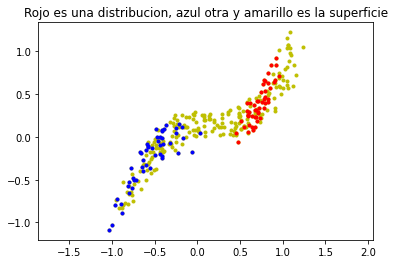

In [30]:
n=100
eps=0.3
#creo que es que los kernels se hacen tremendamente chicos, habria que normalizar por la dimension de la variedad en la que trabajo, lo que ni idea
#mas facil volar esa normalizacion como volumen del abola d dimensional y ya

data1=np.array([np.linspace(-1,1,n),np.linspace(-1,1,n)**3]).T+np.random.random((n,2))*eps
data2=np.array([np.linspace(-1,1,n),np.linspace(-1,1,n)**3]).T+np.random.random((n,2))*eps
data=np.concatenate((data1,data2),axis=0)

n_samples=50

z2=np.random.normal(loc=-0.5,scale=0.25,size=n_samples).reshape(-1,1)
z2=np.concatenate((z2,np.random.normal(loc=0.7,scale=0.1,size=n_samples).reshape(-1,1)),axis=0)
zaux=np.concatenate((z2,z2),axis=1)
zaux[:,1]=zaux[:,1]**3


samples=zaux
aux=np.random.random(samples.shape[0])*0.4-0.2
samples[:,1]=samples[:,1]+aux

data=np.concatenate((data,samples),axis=0)

plt.plot(data[:,0],data[:,1],'.',c='y')
plt.plot(samples[n_samples:,0],samples[n_samples:,1],'.',c='r')
plt.plot(samples[:n_samples,0],samples[:n_samples,1],'.',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

In [31]:
#z2=np.matrix([0 for i in range(n_samples)]+[1 for i in range(n_samples)]).T
#le pongo label 0 a la primera y 1 a la segunda

alpha2=2
k2=20
dimension2=2
f_dist2,tree2=fermat_graph(data,alpha=alpha2)

def my_fermat_cost2(x,initialData):
    return fermat_cost_cuad_fast(x,initialData,dimension2,f_dist2,tree2,data,k2,alpha2)

In [32]:
def prueba2(g,gg,q,qq,h):
    n_iter=400
    learningrate0=1
    landamax=1e2
    
    
    landa0=g
    beta_adapt=gg

    
    h=h
    quantil2=q
    q2=qq
    fctr=1
    #cost_function=euclidean_cost_fast
    def cero(a,b):
      return 0, np.zeros(a.shape)
    cost_function=my_fermat_cost2
    #cost_function=cero

    yinit=samples
    #yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
    bb=1

    monoton=True
    clb=True
    #clb=False
    cat=False
    
    return barycenter_fermat(yinit,n_iter,samples,landa0,landamax,learningrate0,z2,h,beta_adapt,cost_function,f_dist2,tree2,data,k2,alpha2,landa_monotono=monoton,factor=fctr,quant=quantil2,quant2=q2,b=bb,categorical=cat,callback=clb)

In [33]:
def plot2(bari2,g,gg,q,qq,h):
  plt.plot(data[:,0],data[:,1],'.',c='y')
  #plt.plot(samples[n_samples:,0],samples[n_samples:,1],'.',c='r')
  #plt.plot(samples[:n_samples,0],samples[:n_samples,1],'.',c='b')
  plt.plot(bari2[:n_samples,0],bari2[:n_samples,1],'x',c='b')
  plt.plot(bari2[n_samples:,0],bari2[n_samples:,1],'x',c='r')
  plt.axis('equal')
  plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
  plt.title('landa0:'+str(g)+", bbeta_adapt:"+str(gg)+", quant:"+str(q)+", quant2:"+str(qq)+", h:"+str(h))
  plt.show()

it: 0, paso: 2.1252553677778524e-08, landa: 0.001, h:0.21201147385115363
it: 1, paso: 7.969707549949542e-09, landa: 0.0015, h:0.12956104785983666
it: 2, paso: 2.727350930589419e-09, landa: 0.0022500000000000003, h:0.11416772364598397
it: 3, paso: 1.0283244654252433e-08, landa: 0.0033750000000000004, h:0.10652928520269088
it: 4, paso: 0.2848833063698161, landa: 0.005062500000000001, h:0.09923260761931382
it: 5, paso: 0.29120371278408214, landa: 0.005062500000000001, h:0.09392107836423393
it: 6, paso: 0.2879564069284317, landa: 0.005062500000000001, h:0.09033367966166132
it: 7, paso: 0.2829723905876679, landa: 0.005062500000000001, h:0.08696573135193358
it: 8, paso: 0.269102700988659, landa: 0.005062500000000001, h:0.08448632717375708
it: 9, paso: 0.2718341749155948, landa: 0.005062500000000001, h:0.08125727421725266
it: 10, paso: 0.2747368185466185, landa: 0.005062500000000001, h:0.07865018893286116
it: 11, paso: 0.283269163595701, landa: 0.005062500000000001, h:0.07538855496754114
it: 

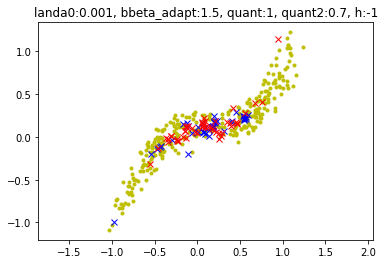

In [34]:
gg=1.5
h=-1
g=0.001
q=1
qq=0.7
plot2(prueba2(g,gg,q,qq,h),g,gg,q,qq,h)